## Defining Noisy Environment ##

In [1]:
from tqdm import tqdm
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

In [2]:
mndata = MNIST('data')
x_train_data, y_train_data = mndata.load_training()
x_test_data, y_test_data = mndata.load_testing()

training_steps=25000
checkpoint_loss=1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

class NoisyMnistEnv:
    def __init__(self, split, input_number_min, input_number_max, batch_size=64, seed=0):
        self.seed = seed
        self.split = split
        if self.split == "train":
            self.x, self.y = x_train_data, y_train_data
        elif self.split == "test":
            self.x, self.y = x_test_data, y_test_data
        self.batch_size = batch_size
        self.input_number_min = input_number_min
        self.input_number_max = input_number_max
        
    
    def step(self):
        x_arr = np.zeros((self.batch_size, 28 * 28))
        y_arr = np.zeros((self.batch_size, 28 * 28))

        for i in range(self.batch_size):
            input_number = np.random.randint(self.input_number_min, self.input_number_max)
            if input_number == 0:
                output_number = 0
            if input_number == 1:
                output_number = np.random.randint(2, 10)
            input_data = self.get_random_sample_of_number(input_number)
            if input_number == 1:
                output_data = self.get_random_sample_of_number(output_number)
            elif input_number == 0:
                output_data = input_data
            x_arr[i] = np.array(input_data)
            y_arr[i] = np.array(output_data)
        return x_arr, y_arr
    
    def get_random_sample_of_number(self, number):
        random_num = np.random.randint(0, len(self.y) - 1)
        if self.y[random_num] == number:
            return self.x[random_num]
        else:
            return self.get_random_sample_of_number(number)

device: cuda


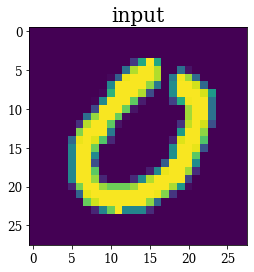

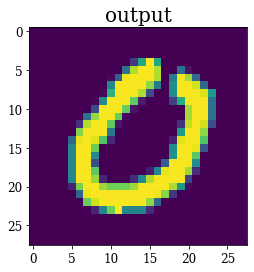

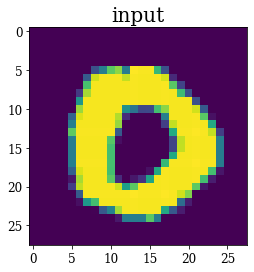

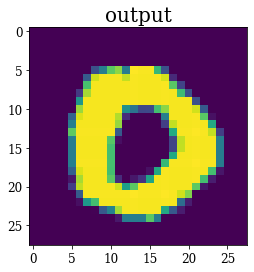

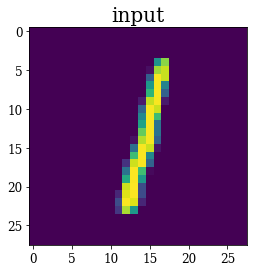

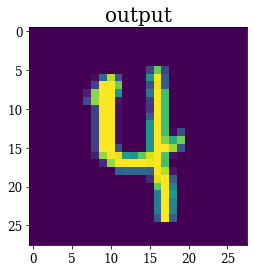

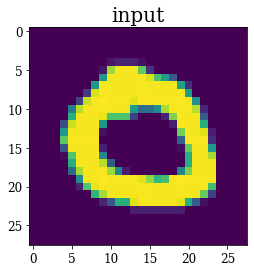

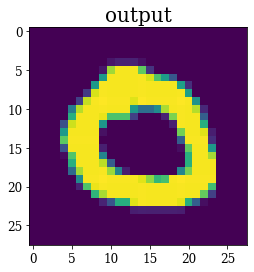

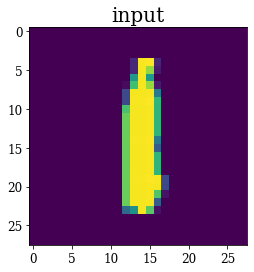

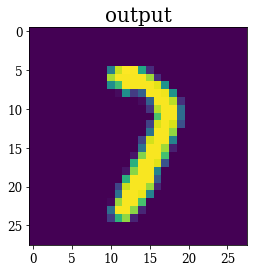

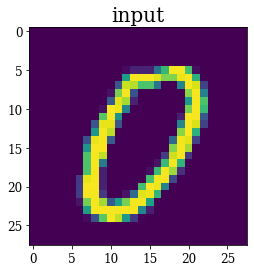

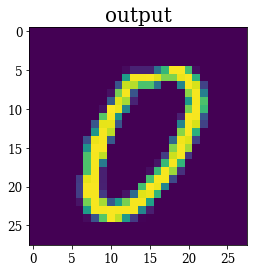

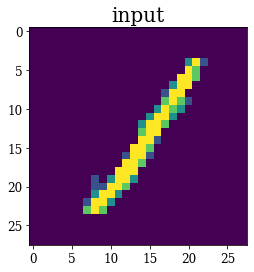

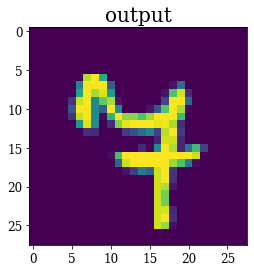

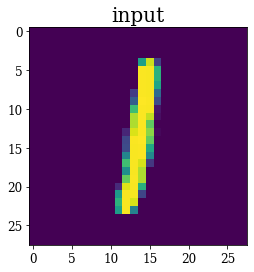

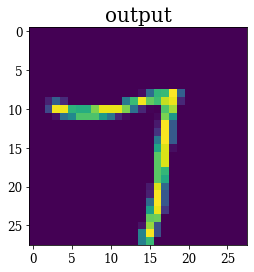

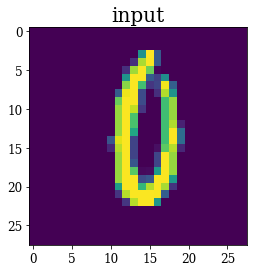

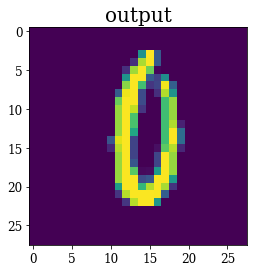

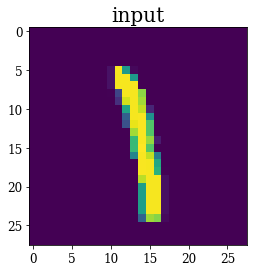

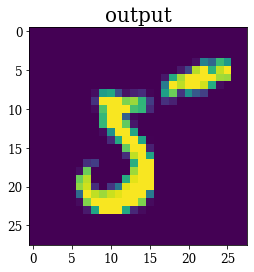

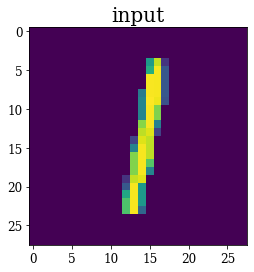

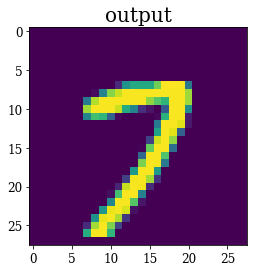

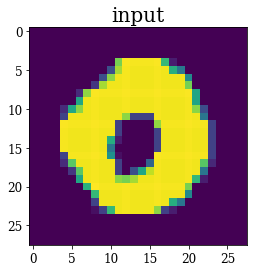

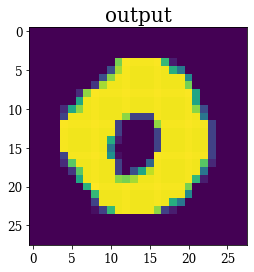

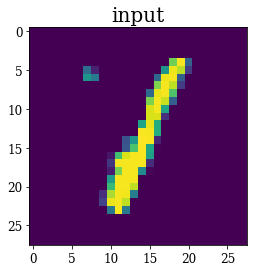

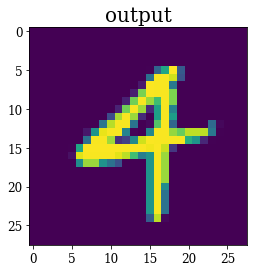

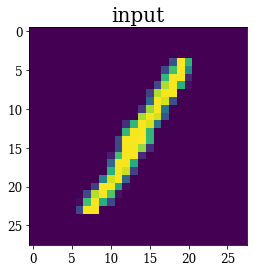

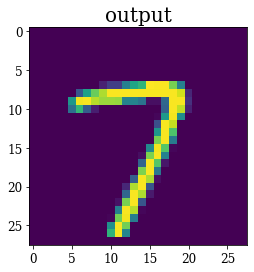

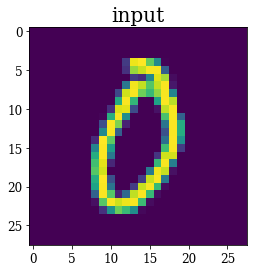

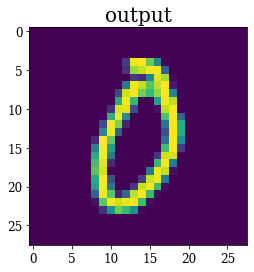

In [3]:
mnist_env = NoisyMnistEnv("train", 0, 2)
x, y  = mnist_env.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

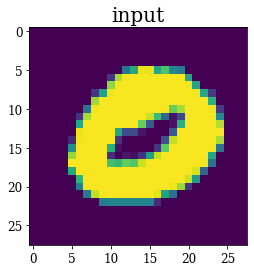

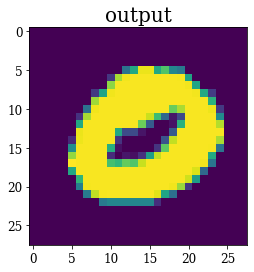

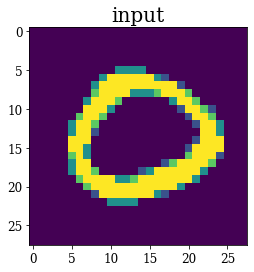

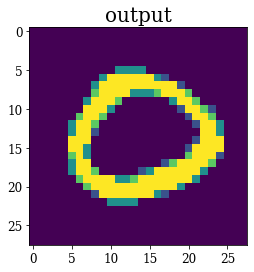

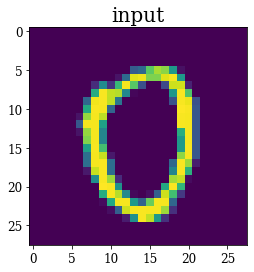

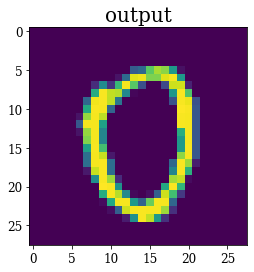

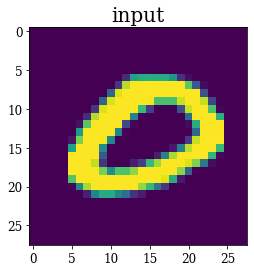

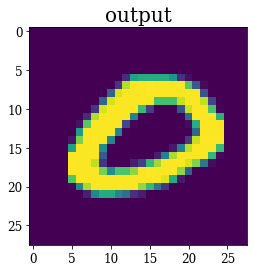

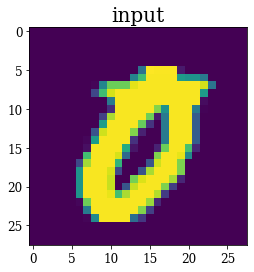

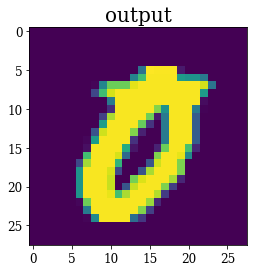

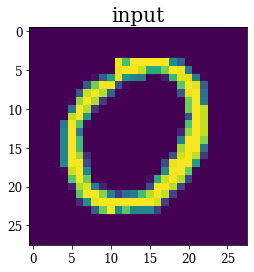

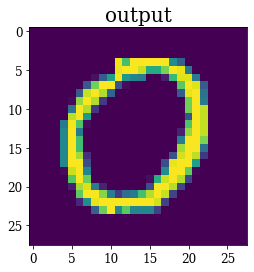

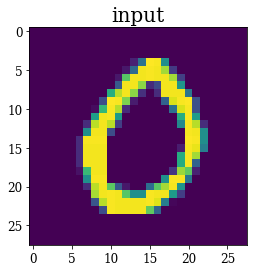

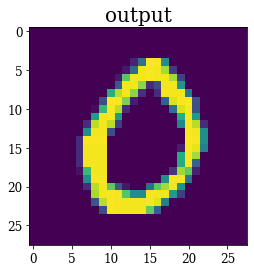

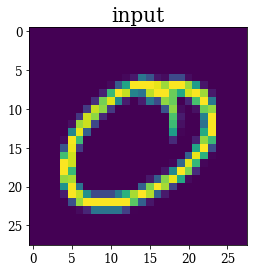

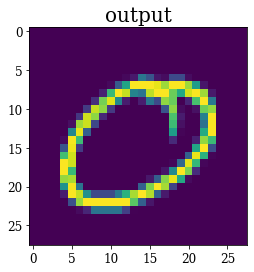

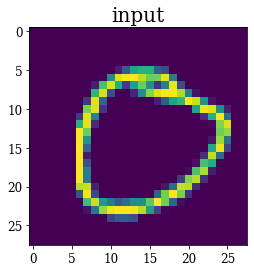

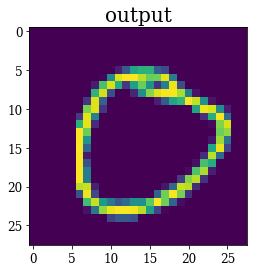

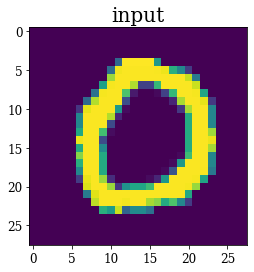

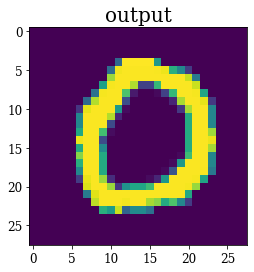

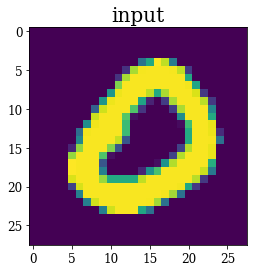

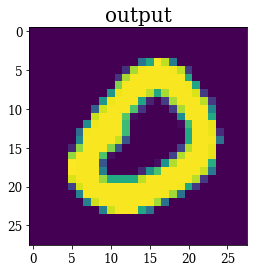

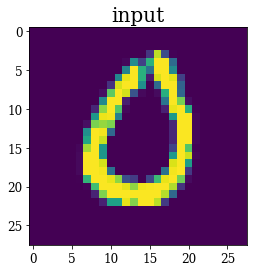

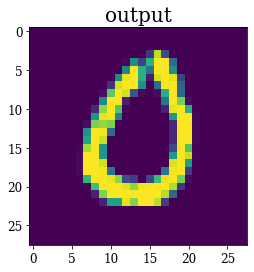

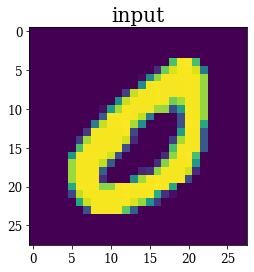

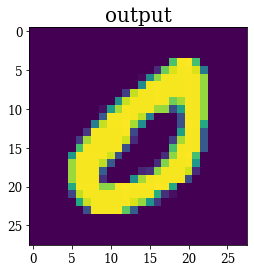

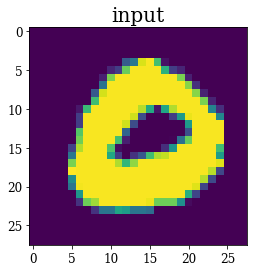

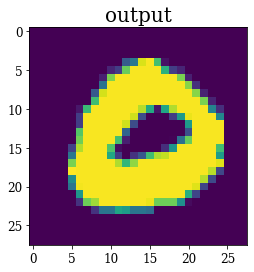

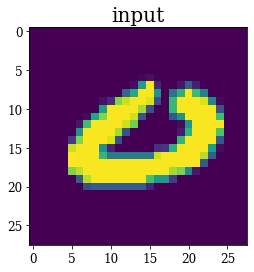

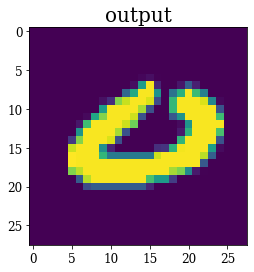

In [4]:
mnist_env_zeros = NoisyMnistEnv("test", 0, 1)
x, y  = mnist_env_zeros.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

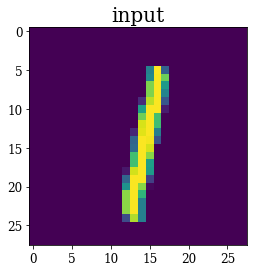

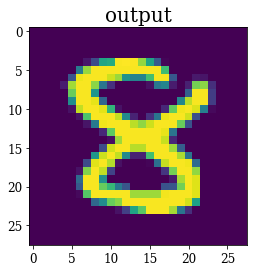

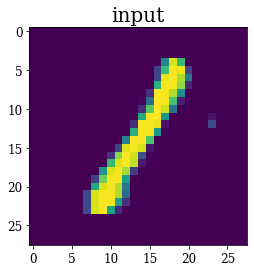

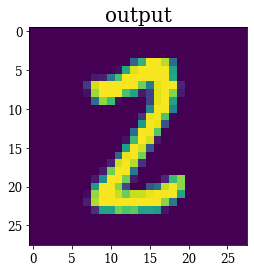

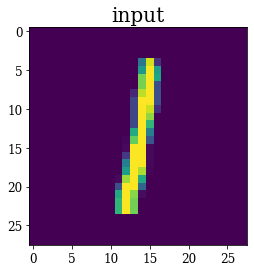

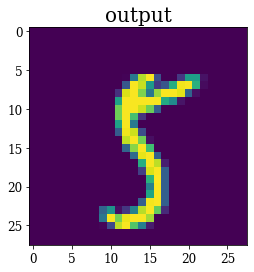

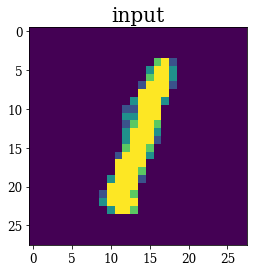

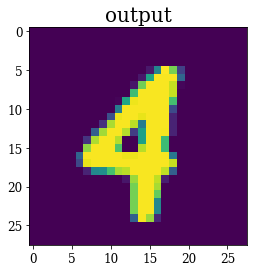

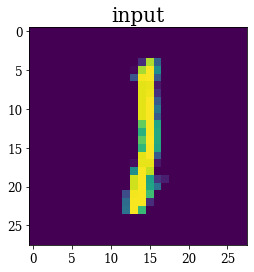

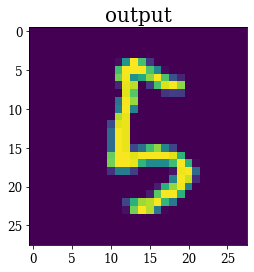

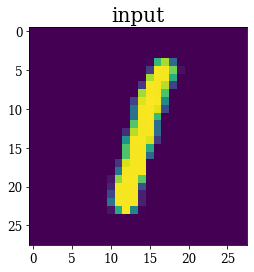

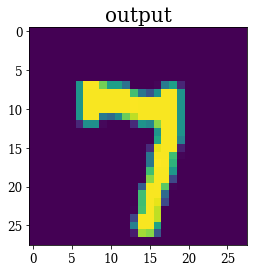

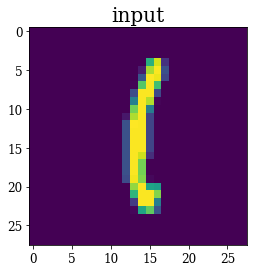

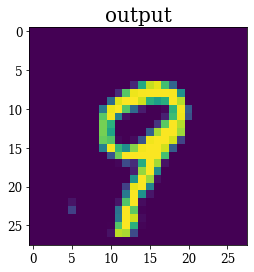

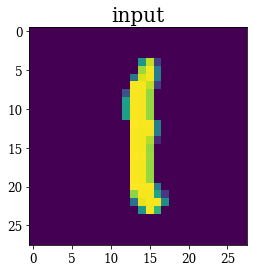

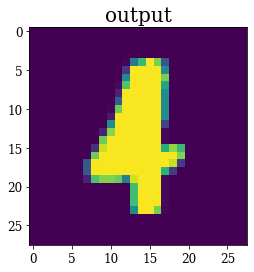

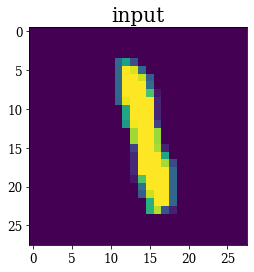

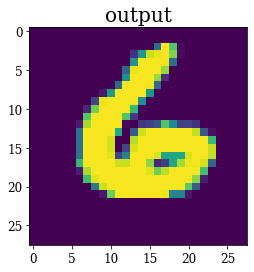

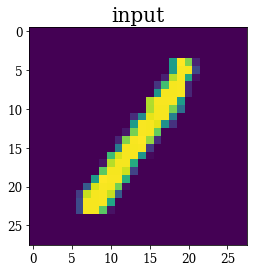

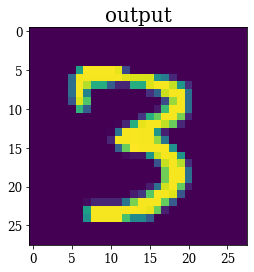

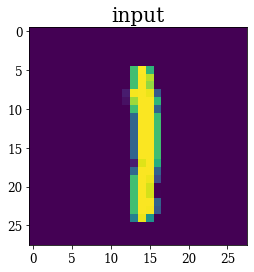

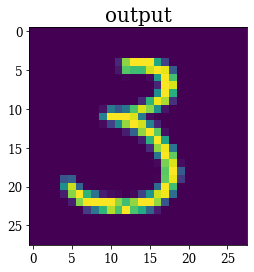

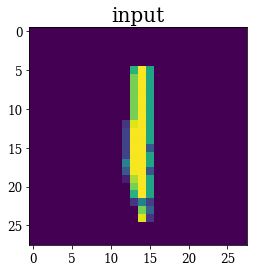

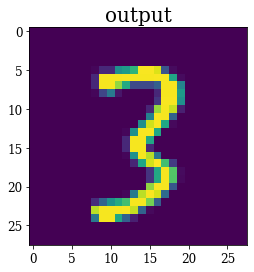

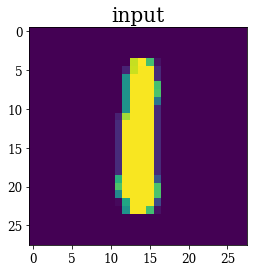

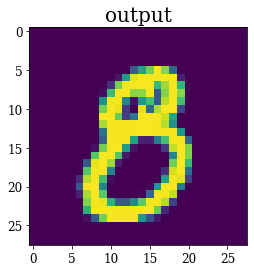

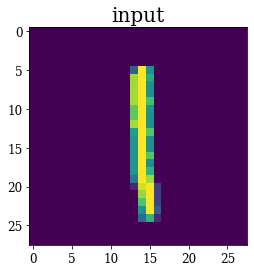

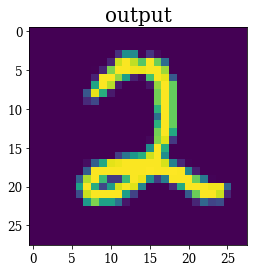

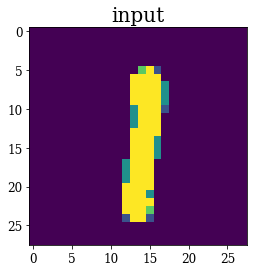

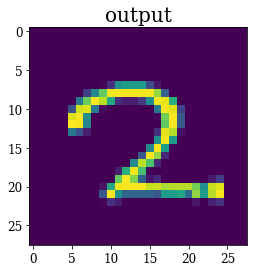

In [5]:
mnist_env_ones = NoisyMnistEnv("test", 1, 2)
x, y  = mnist_env_ones.step()
count = 0
for i in zip(x,y):
    count += 1
    if count == 16:
        break
    plt.title("input", fontsize=20)
    plt.imshow(np.squeeze(i[0]).reshape(28, 28))
    plt.show()
    plt.title("output", fontsize=20)
    plt.imshow(np.squeeze(i[1]).reshape(28, 28))
    plt.show()

## Defining Models ##

In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# from here https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, 128)
        self.linear_4 = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = F.relu(self.linear_3(x))
        x = (self.linear_4(x))
        return x
    
# from here https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class AleatoricNet(nn.Module):
    def __init__(self):
        super(AleatoricNet, self).__init__()
        self.linear_1 = nn.Linear(28 * 28, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3_mu = nn.Linear(128, 128)
        self.linear_4_mu = nn.Linear(128, 28 * 28)
        self.linear_3_sigma = nn.Linear(128, 128)
        self.linear_4_sigma = nn.Linear(128, 28 * 28)
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        mu = F.relu(self.linear_3_mu(x))
        mu = (self.linear_4_mu(mu))
        log_sigma = F.relu(self.linear_3_sigma(x))
        log_sigma = (self.linear_4_sigma(log_sigma))
        return mu, log_sigma

### Vanilla ###

100%|██████████| 25000/25000 [13:09<00:00, 31.67it/s]


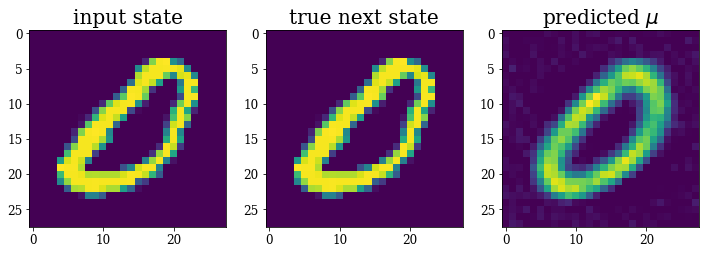

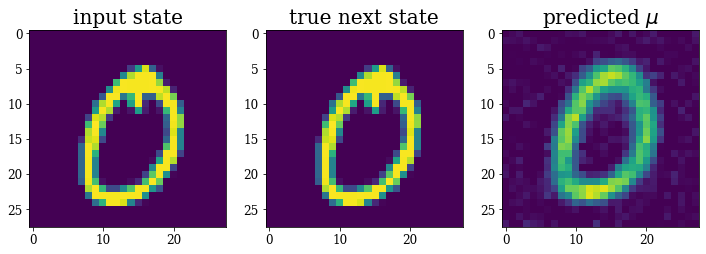

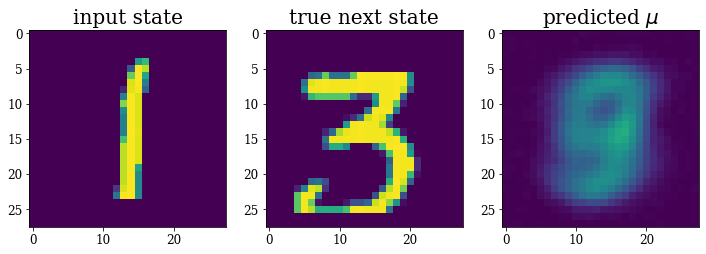

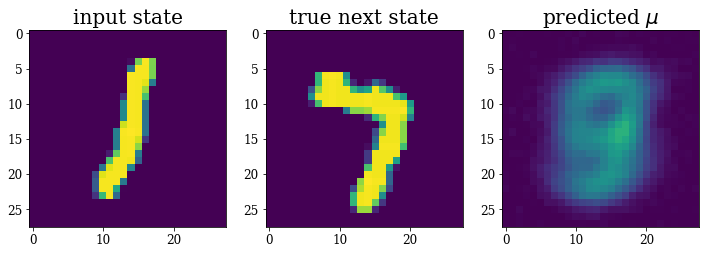

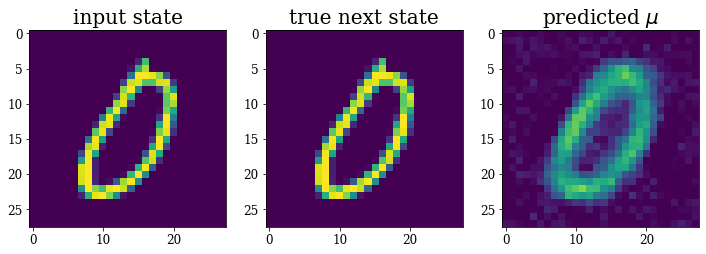

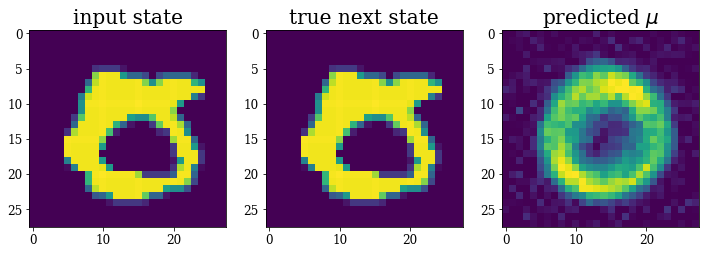

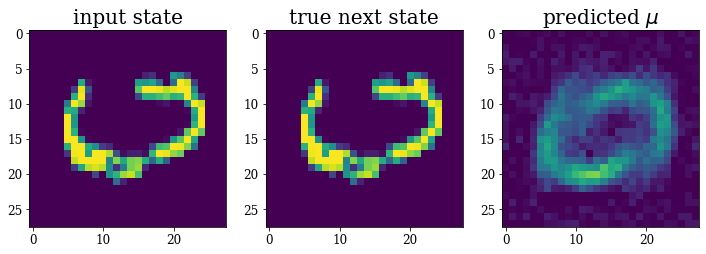

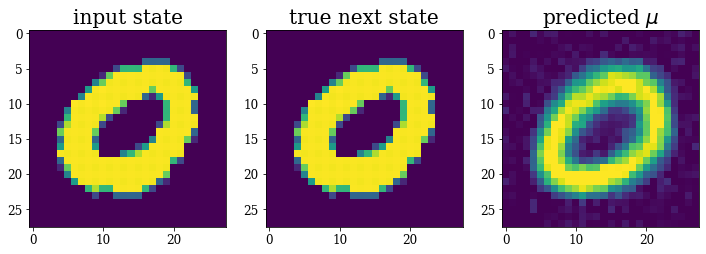

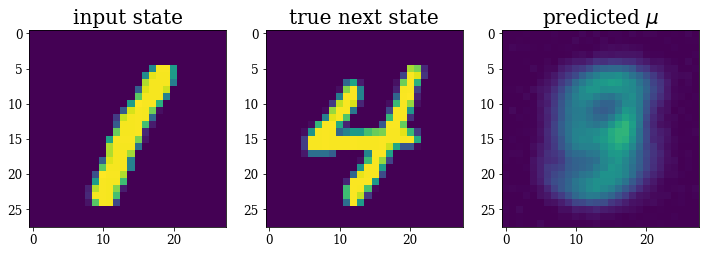

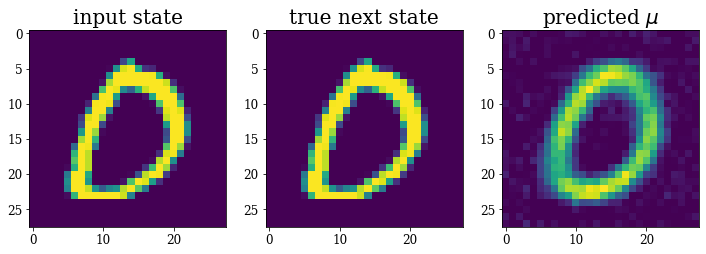

100%|██████████| 25000/25000 [13:07<00:00, 31.74it/s]


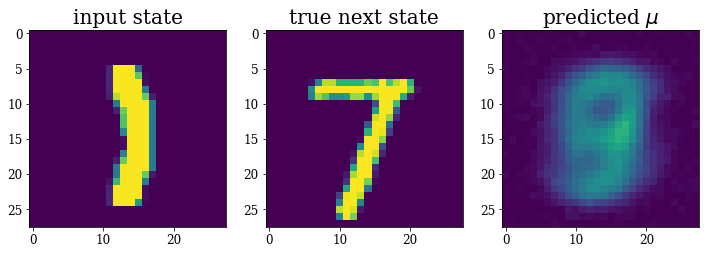

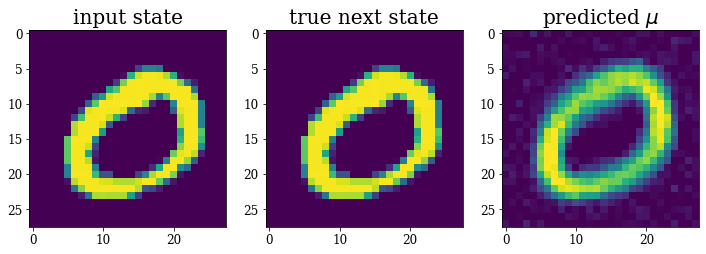

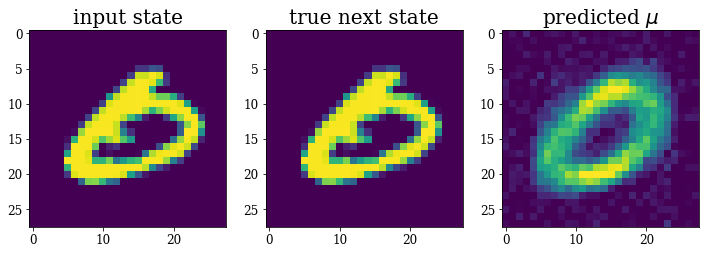

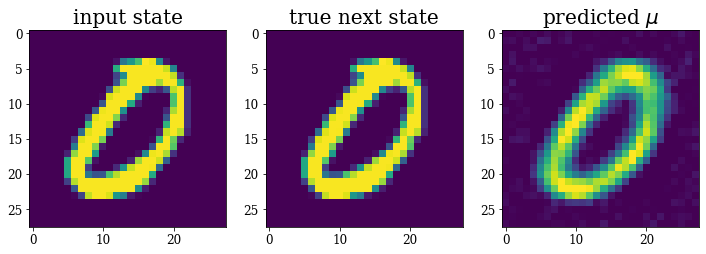

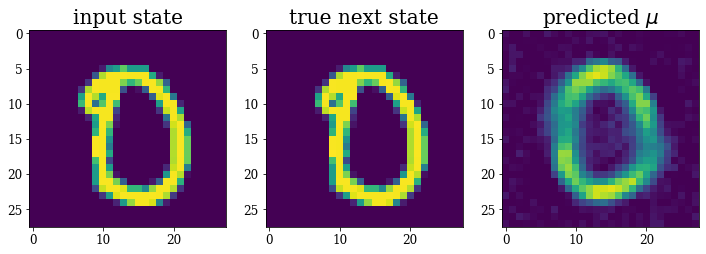

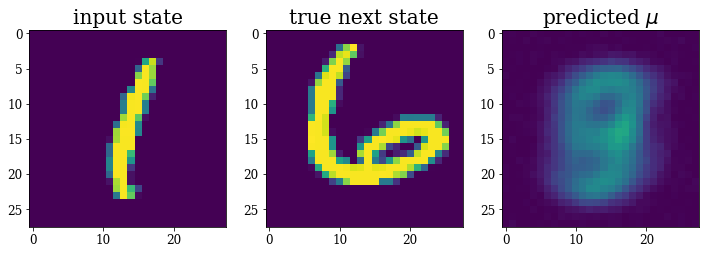

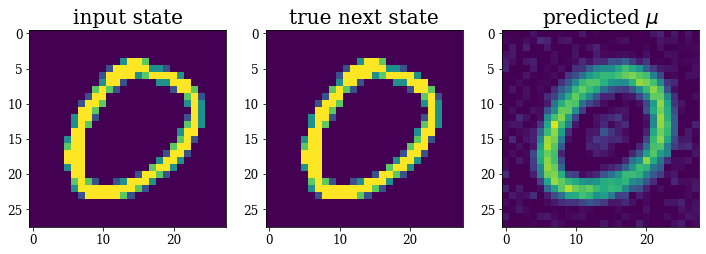

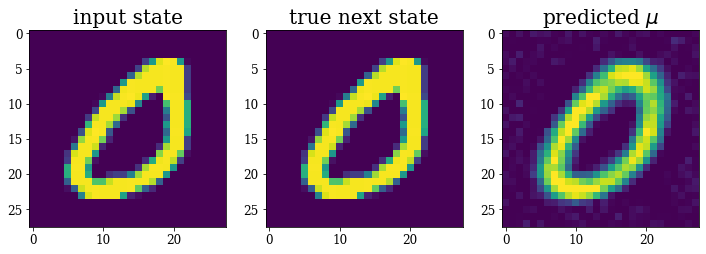

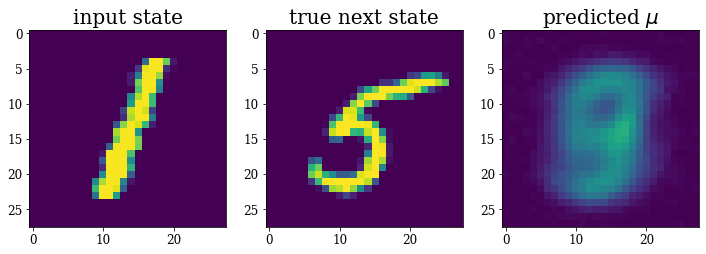

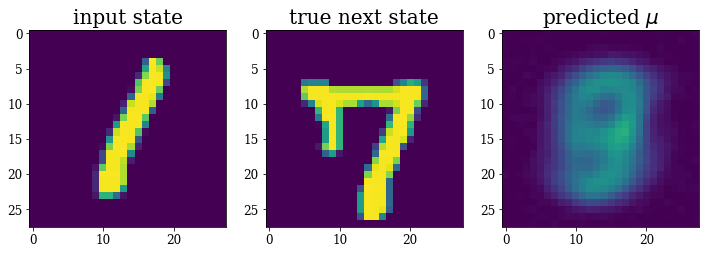

100%|██████████| 25000/25000 [13:13<00:00, 31.49it/s]


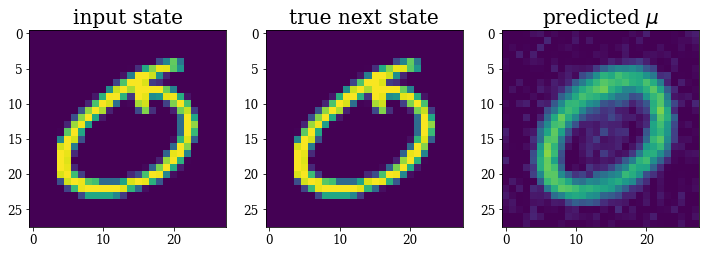

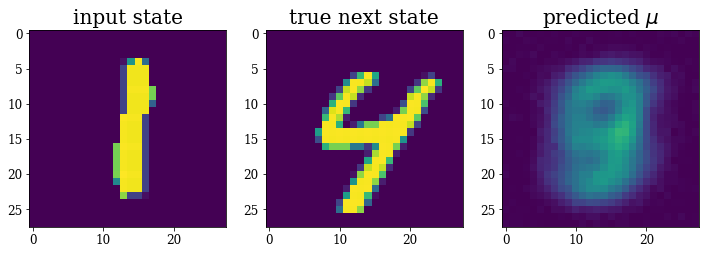

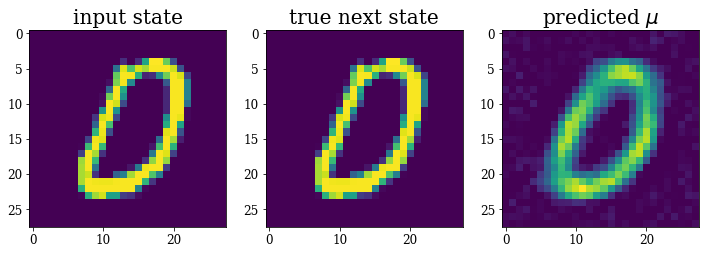

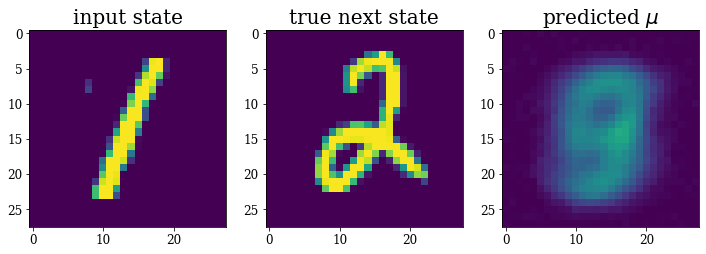

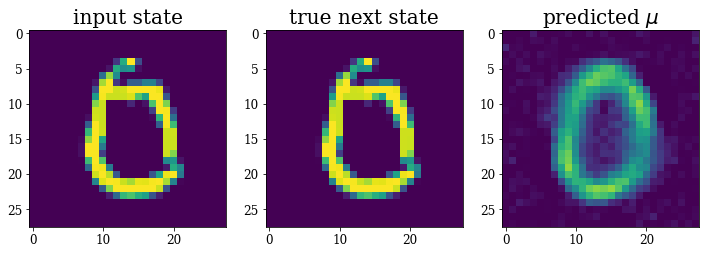

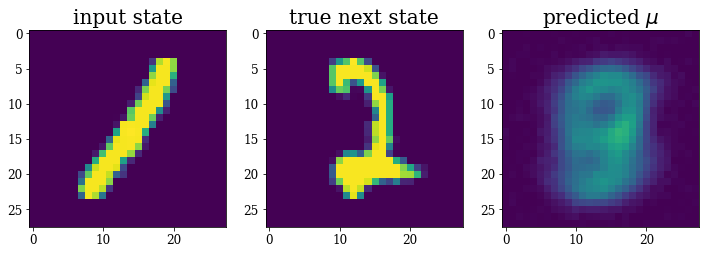

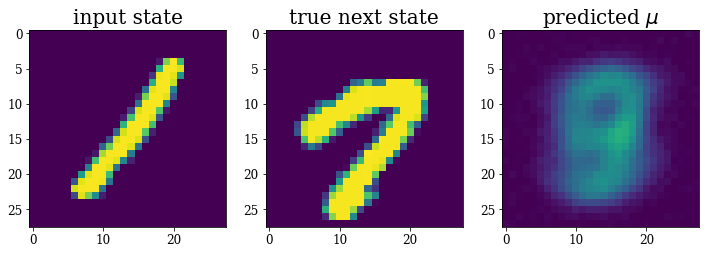

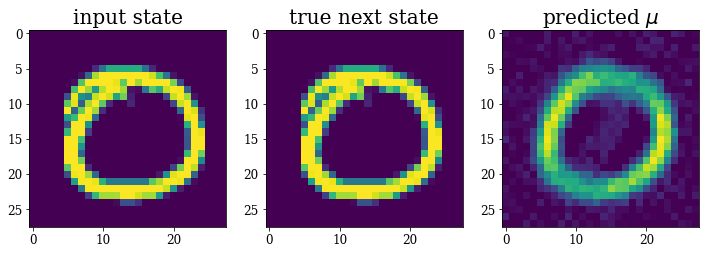

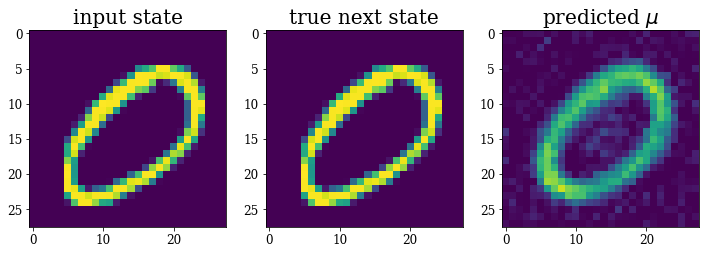

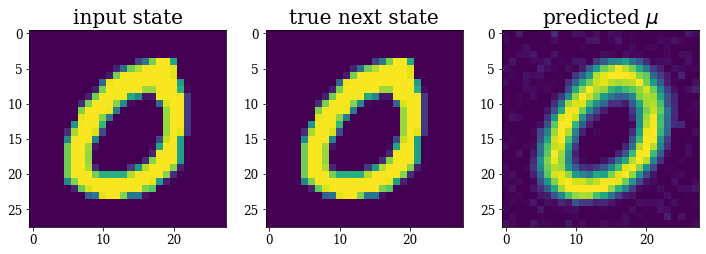

In [7]:
repeats = 3

for repeat in range(repeats):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)

    loss_list = []
    loss_buffer = []
    loss_list_0 = []
    loss_list_1 = []
    loss_buffer_0 = []
    loss_buffer_1 = []
    for update in tqdm(range(int(training_steps))):
        model.train()
        data, target = mnist_env.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss_buffer.append(loss)
        if update % checkpoint_loss == 0:
            loss_list.append(torch.mean(torch.stack(loss_buffer)).detach().cpu().numpy())
            loss_buffer = []

        model.eval()
        data, target = mnist_env_zeros.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        output = model(data)
        loss_0 = F.mse_loss(output, target)
        loss_buffer_0.append(loss_0)
        if update % checkpoint_loss == 0:
            loss_list_0.append(torch.mean(torch.stack(loss_buffer_0)).detach().cpu().numpy())
            loss_buffer_0 = []

        model.eval()
        data, target = mnist_env_ones.step()
        data /= 255
        target /= 255
        data = torch.from_numpy(data).float().to(device)
        target = torch.from_numpy(target).float().to(device)
        output = model(data)
        loss_1 = F.mse_loss(output, target)
        loss_buffer_1.append(loss_1)
        if update % checkpoint_loss == 0:
            loss_list_1.append(torch.mean(torch.stack(loss_buffer_1)).detach().cpu().numpy())
            loss_buffer_1 = []

    data, target = mnist_env.step()
    predictions = model(torch.from_numpy(data).float().to(device)/255)

    for i in range(10):
        w=10
        h=10
        fig=plt.figure(figsize=(12, 12))
        columns = 3
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
        plt.title("input state", fontsize=20)

        fig.add_subplot(rows, columns, 2)
        plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
        plt.title("true next state", fontsize=20)

        fig.add_subplot(rows, columns, 3)
        plt.imshow(predictions[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
        plt.title("predicted $\mu$", fontsize=20)
        plt.show()
        
    np.save("lost_list_0_" + str(repeat) + ".npy", loss_list_0)
    np.save("lost_list_1_" + str(repeat) + ".npy", loss_list_1)

### Aleatoric ###

In [8]:
# for repeat in range(repeats):
#     model = AleatoricNet().to(device)
#     optimizer = optim.Adadelta(model.parameters(), lr=0.1)
#     model.train()
#     loss_list_aleatoric = []
#     loss_buffer = []
#     loss_list_0_aleatoric = []
#     loss_list_1_aleatoric = []
#     loss_buffer_0 = []
#     loss_buffer_1 = []

#     for update in tqdm(range(int(training_steps))):
#         model.train()
#         data, target = mnist_env.step()
#         data /= 255
#         target /= 255
#         data = torch.from_numpy(data).float().to(device)
#         target = torch.from_numpy(target).float().to(device)
#         optimizer.zero_grad()
#         mu, log_sigma = model(data)
#         mse = F.mse_loss(mu, target, reduction="none")
#         loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
#         loss.backward()
#         optimizer.step()
#         loss_buffer.append(torch.mean(mse - torch.exp(log_sigma)))
#         if update % checkpoint_loss == 0:
#             loss_list_aleatoric.append(torch.mean(torch.stack(loss_buffer)).detach().cpu().numpy())
#             loss_buffer = []

#         model.eval()
#         data, target = mnist_env_zeros.step()
#         data /= 255
#         target /= 255
#         data = torch.from_numpy(data).float().to(device)
#         target = torch.from_numpy(target).float().to(device)
#         optimizer.zero_grad()
#         mu, log_sigma = model(data)
#         mse = F.mse_loss(mu, target, reduction="none")
#         loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
#         loss_buffer_0.append(torch.mean(mse - torch.exp(log_sigma)))
#         if update % checkpoint_loss == 0:
#             loss_list_0_aleatoric.append(torch.mean(torch.stack(loss_buffer_0)).detach().cpu().numpy())
#             loss_buffer_0 = []

#         model.eval()
#         data, target = mnist_env_ones.step()
#         data /= 255
#         target /= 255
#         data = torch.from_numpy(data).float().to(device)
#         target = torch.from_numpy(target).float().to(device)
#         optimizer.zero_grad()
#         mu, log_sigma = model(data)
#         mse = F.mse_loss(mu, target, reduction="none")
#         loss = torch.mean(torch.exp(-log_sigma) * mse + log_sigma)
#         loss_buffer_1.append(torch.mean(mse - torch.exp(log_sigma)))
#         if update % checkpoint_loss == 0:
#             loss_list_1_aleatoric.append(torch.mean(torch.stack(loss_buffer_1)).detach().cpu().numpy())
#             loss_buffer_1 = []

#     data, target = mnist_env.step()
#     mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

#     for i in range(10):
#         w=10
#         h=10
#         fig=plt.figure(figsize=(12, 12))
#         columns = 4
#         rows = 1
#         fig.add_subplot(rows, columns, 1)
#         plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
#         plt.title("input state", fontsize=20)

#         fig.add_subplot(rows, columns, 2)
#         plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
#         plt.title("true next state", fontsize=20)

#         fig.add_subplot(rows, columns, 3)
#         plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
#         plt.title("predicted $\mu$", fontsize=20)

#         fig.add_subplot(rows, columns, 4)
#         plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=0, vmax=1)
#         plt.title("predicted $\sigma$", fontsize=20)

#         plt.show()
#     np.save("aleatoric_lost_list_0_" + str(repeat) + ".npy", loss_list_0_aleatoric)
#     np.save("aleatoric_lost_list_1_" + str(repeat) + ".npy", loss_list_1_aleatoric)

In [9]:
data, target = mnist_env.step()
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=2000, facecolor='w', edgecolor='k')
title_size = 25
cmap='bone'

for i in range(3):
    w=10
    h=10
    fig=plt.figure(figsize=(18, 18))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Input", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Output", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\mu$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\sigma$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 5)
    plt.imshow(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28), vmin=0, vmax=1, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("MSE Error", fontsize=title_size)

    fig.add_subplot(rows, columns, 6)
    plt.imshow(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("AMA Error", fontsize=title_size)

    plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
data, target = mnist_env.step()
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=2000, facecolor='w', edgecolor='k')
title_size = 12
cmap='twilight'
lower_color, higher_color = -1.25, 1.25 

for i in range(3):
    
    w=10
    h=10
    fig=plt.figure(figsize=(18, 18))
    columns = 6
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Input", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title(r"Output", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\mu$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("Pred. $\sigma$", fontsize=title_size)
    
    fig.add_subplot(rows, columns, 5)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28, 28)
    avg_error = np.mean(error)
    plt.imshow(error, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("MSE Error", fontsize=title_size)

    fig.add_subplot(rows, columns, 6)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28) 
    plt.imshow(error, vmin=-1, vmax=1, cmap=cmap)
    plt.clim(lower_color,higher_color) 
    avg_error = np.mean(error)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.title("AMA Error", fontsize=title_size)
    #print(((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28,28) - np.exp(sigma[i].detach().cpu().numpy()).reshape(28, 28))
    #if i == 0:~}
    cbar= plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(30)
    plt.show()

In [ ]:
data, target = mnist_env.step()
mu, sigma = model(torch.from_numpy(data).float().to(device)/255)

for i in range(10):
    w=10
    h=10
    fig=plt.figure(figsize=(12, 12))
    columns = 5
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(data[i].reshape(28, 28)/255, vmin=0, vmax=1)
    plt.title("input state", fontsize=20)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(target[i].reshape(28, 28)/255, vmin=0, vmax=1)
    plt.title("true next state", fontsize=20)

    fig.add_subplot(rows, columns, 3)
    plt.imshow(mu[i].detach().cpu().numpy().reshape(28, 28), vmin=0, vmax=1)
    plt.title("predicted $\mu$", fontsize=20)

    fig.add_subplot(rows, columns, 4)
    plt.imshow(np.sqrt(np.exp((sigma[i].detach().cpu().numpy().reshape(28, 28)))), vmin=0, vmax=1)
    plt.title("predicted $\sigma$", fontsize=20)

    fig.add_subplot(rows, columns, 5)
    error = ((mu[i].detach().cpu().numpy() - target[i]/255)**2).reshape(28, 28)
    avg_error = np.mean(error)
    plt.imshow(error, vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    #if i == 0:
    plt.title(str(avg_error), fontsize=title_size)
    plt.show()

In [ ]:
updates = [x * 1000 for x in list(range(len(loss_list_0_aleatoric)))]
plt.plot(updates,loss_list_0_aleatoric,label="Aleatoric Net Less Stochastic")
plt.plot(updates,loss_list_1_aleatoric,label="Aleatoric Net More Stochastic")
plt.plot(updates,loss_list_0,label="Vanilla Net Less Stochastic")
plt.plot(updates,loss_list_1,label="Vanilla Net More Stochastic")
plt.legend(loc="best", fontsize=12)
plt.ylabel("Intrinsic Reward", fontsize=15)
plt.xlabel("Update step", fontsize=15)
plt.ylim(-0.05, 0.2)
plt.title("Noisy MNIST", fontsize=20)

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=1000, facecolor='w', edgecolor='k')
from matplotlib import rcParams
rcParams['axes.titlepad'] =2 

def load_files_into_arr(list_of_file_paths):
    all_arrs = []
    for a_file in list_of_file_paths:
        all_arrs.append(np.load(a_file))
    return all_arrs

def get_mean_and_std_dev(arr_of_results):
    return np.mean(arr_of_results, axis=0), np.std(arr_of_results, axis=0)

def plot_mean_and_std(mean, std, label):
    assert len(mean) == len(std)
    if "stochastic" in label:
        linestyle="-"
    else:
        linestyle="--"
    if "AMA" in label:
        color="forestgreen"
    else:
        color="darkmagenta"
    plt.plot(list(range(len(mean))), mean, linestyle=linestyle, label=label, color=color)
    x = list(range(len(mean)))
    plt.fill_between(x, (mean-std), (mean+std), alpha=0.2, color=color)

import glob
npy_files = glob.glob("*npy")
aleatoric_stochastic = [file for file in npy_files if "_0." in file and "aleatoric" in file]
aleatoric_deterministic = [file for file in npy_files if "_1." in file and "aleatoric" in file]
vanilla_deterministic = [file for file in npy_files if "aleatoric" not in file and "_0." in file]
vanilla_stochastic = [file for file in npy_files if "aleatoric" not in file and "_1." in file]

list_of_file_lists =[vanilla_stochastic, vanilla_deterministic, aleatoric_stochastic, aleatoric_deterministic,]

legends = [r"MSE stochastic",
           r"MSE deterministic",
           r"AMA stochastic",
           r"AMA deterministic"]

colors = ["darkmagenta", "forestgreen"]
plt.xlim(0, 50)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

for i, files in enumerate(list_of_file_lists):
    results = load_files_into_arr(files)
    mu, sigma = get_mean_and_std_dev(results)
    plot_mean_and_std(mu, sigma, legends[i])

plt.rc('font', family='serif')
plt.legend(loc="best", fontsize=20)
plt.ylabel("Intrinsic Reward", fontsize=24)
plt.xlabel(r"Update Step $\times 10 ^{3}$", fontsize=24)
plt.ylim(-0.05, 0.2)
plt.title("Noisy MNIST", fontsize=29)